In [2]:
# Importing the toolbox (takes several seconds)
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py

In [3]:
h5_file_path = "/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119976_shuffle1_400000.h5"  
#this is from mouse-id 1119976
#6559 second multi_shel starts
dataframe = pd.read_hdf(h5_file_path)

In [148]:
dataframe.head()

scorer    DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000              \
bodyparts                                                  nose               
coords                                                        x           y   
0                                                 539.256104     623.672302   
1                                                 539.282654     623.888306   
2                                                 538.950134     624.782471   
3                                                 538.895203     631.843323   
4                                                 537.829651     631.330017   

scorer                                                               \
bodyparts             headcenter                               neck   
coords    likelihood           x           y likelihood           x   
0           0.303823  541.898193  622.511108   0.631783  549.215027   
1           0.283556  541.876099  622.773499   0.607700  549.170654   
2           0.193696  541.344116  623.716309   0.569051  548.799988   
3           0.208650  541.977905  627.653687   0.665515  548.301819   
4           0.251946  540.821472  627.467407   0.764026  547.646912   

scorer                                        ...                         \
bodyparts                           rightear  ... bodycenter    tailbase   
coords              y likelihood           x  ... likelihood           x   
0          623.278992   0.936279  546.210876  ...   0.986360  576.820618   
1          623.484436   0.925951  546.182739  ...   0.981908  576.579773   
2          624.039612   0.929432  545.563354  ...   0.982450  576.470886   
3          624.995056   0.937730  544.634583  ...   0.983622  576.714050   
4          624.892700   0.933067  544.711121  ...   0.976737  577.102417   

scorer                                                               \
bodyparts                                 t1                          
coords              y likelihood           x           y likelihood   
0          607.295471   0.886090  596.236145  600.292297   0.010224   
1          604.644287   0.859571  598.696655  591.309631   0.006786   
2          604.535400   0.866205  599.042725  590.925537   0.009630   
3          604.796814   0.858597  599.135376  590.208679   0.007577   
4          605.304138   0.872187  596.610352  598.666321   0.002107   

scorer                                        
bodyparts          t2                         
coords              x           y likelihood  
0          611.906250  594.003418   0.202277  
1          613.130920  592.384644   0.098123  
2          613.550171  591.968933   0.087247  
3          623.458191  595.908203   0.039691  
4          603.562622  599.583801   0.039877  

[5 rows x 39 columns]

In [150]:
import pandas as pd
import logging

class DLCTrackingDataProcessor:
    def __init__(self):
        self.dlc_output = {}
        self.tracking_data_body_parts = {}
        self.dlc_network_name = ''
        self.logger = logging.getLogger(__name__)

    def extract_data_from_dlc_file(self, dataframe, body_parts, scorer) -> None:
        """
        Processes data from a DataFrame outputted from DLC analysis.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the tracking data.
            body_parts (list): List of body parts to track.
            scorer (str): Name of the scorer.
        """

        for body_part in body_parts:
            # Accessing multi-level columns
            self.dlc_output[body_part] = {
                'x': dataframe[scorer, body_part, 'x'],
                'y': dataframe[scorer, body_part, 'y'],
                'likelihood': dataframe[scorer, body_part, 'likelihood']
            }

        self.tracking_data_body_parts['bodyparts'] = body_parts
        self.logger.info(f"The bodyparts tracked by DLC are: {self.tracking_data_body_parts['bodyparts']}")

In [153]:
body_parts = ['nose', 'headcenter', 'neck', 'rightear', 'leftear', 'lefthip', 'righthip', 'leftside', 'rightside', 'bodycenter', 'tailbase', 't1', 't2']
scorer = 'DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000'
processor = DLCTrackingDataProcessor()
processor.extract_data_from_dlc_file(dataframe, body_parts,scorer)

## some DLC utils for plotting

In [36]:
import deeplabcut
deeplabcut.utils.plotting.PlottingResults?

Loading DLC 2.3.0...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


Signature:
deeplabcut.utils.plotting.PlottingResults(
    tmpfolder,
    Dataframe,
    cfg,
    bodyparts2plot,
    individuals2plot,
    showfigures=False,
    suffix='.png',
    resolution=100,
    linewidth=1.0,
)
Docstring: Plots poses vs time; pose x vs pose y; histogram of differences and likelihoods.
File:      ~/miniconda/envs/DLC_post_analysis/lib/python3.11/site-packages/deeplabcut/utils/plotting.py
Type:      function

In [37]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def Histogram(vector,color,bins):
    dvector=np.diff(vector)
    dvector=dvector[np.isfinite(dvector)]
    plt.hist(dvector,color=color,histtype='step',bins=bins)

def PlottingResults(Dataframe,bodyparts2plot,alphavalue=.2,pcutoff=.5,colormap='jet',fs=(4,3)):
    ''' Plots poses vs time; pose x vs pose y; histogram of differences and likelihoods.'''
    plt.figure(figsize=fs)
    colors = get_cmap(len(bodyparts2plot),name = colormap)
    scorer=Dataframe.columns.get_level_values(0)[0] #you can read out the header to get the scorer name!

    for bpindex, bp in enumerate(bodyparts2plot):
        Index=Dataframe[scorer][bp]['likelihood'].values > pcutoff
        plt.plot(Dataframe[scorer][bp]['x'].values[Index],Dataframe[scorer][bp]['y'].values[Index],'.',color=colors(bpindex),alpha=alphavalue)

    plt.gca().invert_yaxis()

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    #plt.savefig(os.path.join(tmpfolder,"trajectory"+suffix))
    plt.figure(figsize=fs)
    Time=np.arange(np.size(Dataframe[scorer][bodyparts2plot[0]]['x'].values))

    for bpindex, bp in enumerate(bodyparts2plot):
        Index=Dataframe[scorer][bp]['likelihood'].values > pcutoff
        plt.plot(Time[Index],Dataframe[scorer][bp]['x'].values[Index],'--',color=colors(bpindex),alpha=alphavalue)
        plt.plot(Time[Index],Dataframe[scorer][bp]['y'].values[Index],'-',color=colors(bpindex),alpha=alphavalue)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    plt.xlabel('Frame index')
    plt.ylabel('X and y-position in pixels')
    #plt.savefig(os.path.join(tmpfolder,"plot"+suffix))

    plt.figure(figsize=fs)
    for bpindex, bp in enumerate(bodyparts2plot):
        Index=Dataframe[scorer][bp]['likelihood'].values > pcutoff
        plt.plot(Time,Dataframe[scorer][bp]['likelihood'].values,'-',color=colors(bpindex),alpha=alphavalue)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    plt.xlabel('Frame index')
    plt.ylabel('likelihood')

    #plt.savefig(os.path.join(tmpfolder,"plot-likelihood"+suffix))

    plt.figure(figsize=fs)
    bins=np.linspace(0,np.amax(Dataframe.max()),100)

    for bpindex, bp in enumerate(bodyparts2plot):
        Index=Dataframe[scorer][bp]['likelihood'].values < pcutoff
        X=Dataframe[scorer][bp]['x'].values
        X[Index]=np.nan
        Histogram(X,colors(bpindex),bins)
        Y=Dataframe[scorer][bp]['x'].values
        Y[Index]=np.nan
        Histogram(Y,colors(bpindex),bins)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bodyparts2plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)
    plt.ylabel('Count')
    plt.xlabel('DeltaX and DeltaY')
    
    #plt.savefig(os.path.join(tmpfolder,"hist"+suffix))

/var/folders/xc/fqjpc3c109d8130c9p4w179nnjty6s/T/ipykernel_59173/1234501165.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(colormap, len(bodyparts2plot))


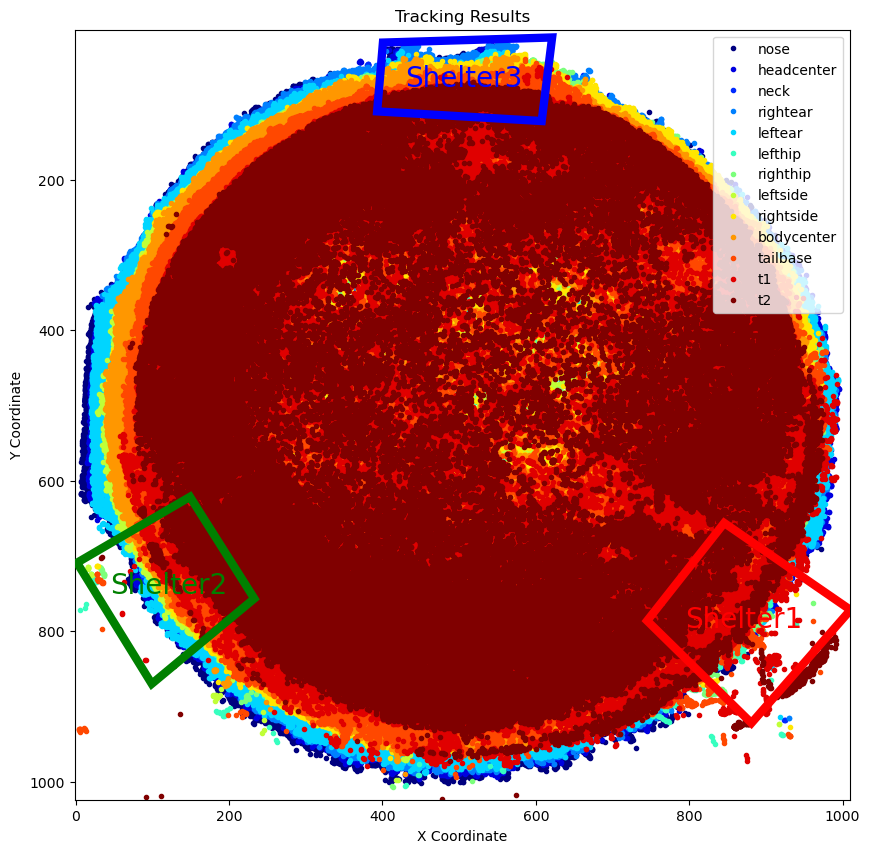

In [200]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Function to draw the ROI on the plot as a polygon
def draw_roi(ax, roi_points, color, label):
    poly = patches.Polygon(roi_points, linewidth=6, edgecolor=color, facecolor='none', closed=True,zorder=5)
    ax.add_patch(poly)
    # Place the label at the centroid of the polygon
    centroid = np.mean(roi_points, axis=0)
    ax.text(centroid[0], centroid[1], label, color=color, ha='center', va='center',size=20)

def PlottingResults(Dataframe, bodyparts2plot, ROIs, alphavalue=.2, pcutoff=.5, colormap='jet', fs=(10,10)):
    plt.figure(figsize=fs)
    scorer = 'DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000'  # Replace with your scorer name
    colors = plt.cm.get_cmap(colormap, len(bodyparts2plot))
    ax = plt.gca()

    for bpindex, bp in enumerate(bodyparts2plot):
        Index = Dataframe[scorer][bp]['likelihood'].values > pcutoff
        ax.plot(Dataframe[scorer][bp]['x'].values[Index], 
                Dataframe[scorer][bp]['y'].values[Index], 
                '.', 
                color=colors(bpindex), 
                alpha=alphavalue, 
                label=bp)
    
    # Draw each shelter ROI
    shelter_colors = ['r', 'g', 'b']  # Different color for each shelter
    for i, (roi_key, roi_points) in enumerate(ROIs.items()):
        draw_roi(ax, roi_points, shelter_colors[i], roi_key)

    # Reverse the y-axis to match the image coordinate system
    ax.invert_yaxis()

    # Adjust plot limits if needed
    plt.xlim([Dataframe[scorer][bodyparts2plot[0]]['x'].min(), Dataframe[scorer][bodyparts2plot[0]]['x'].max()])
    plt.ylim([Dataframe[scorer][bodyparts2plot[0]]['y'].max(), Dataframe[scorer][bodyparts2plot[0]]['y'].min()])

    # Adding legend
    plt.legend()

    # Optionally, add titles and labels
    plt.title("Tracking Results")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")

    plt.show()

# Usage example
bodyparts2plot = ['nose', 'headcenter', 'neck', 'rightear', 'leftear', 'lefthip', 'righthip', 'leftside', 'rightside', 'bodycenter', 'tailbase', 't1', 't2']


PlottingResults(dataframe, bodyparts2plot, ROIs, alphavalue=1, pcutoff=.5,fs=(10,10))
# PlottingResults(dataframe, bodyparts2plot, ROIs, alphavalue=1, pcutoff=.5, fs=(16,16))
# 

## Kalman filter time

In [177]:
# PlottingResults(kalman_results_mouse_1119976_df, bodyparts2plot, ROIs, alphavalue=1, pcutoff=.5, fs=(16,16))


In [178]:
kalman_results_mouse_1119976_df.to_csv('kalman_results_mouse_1119976_df.csv')

In [179]:
kalman_results_mouse_1119976_df

,nose,headcenter,neck,rightear,leftear,lefthip,righthip,leftside,rightside,bodycenter,tailbase,t1,t2
x,"[539.2177586586414, 538.8205612231545, 538.439...","[541.7489116393505, 541.5102026502294, 541.283...","[548.9233237217277, 548.7402126887715, 548.565...","[545.7607889514723, 545.6132903929089, 545.472...","[550.219807713356, 549.9266220635781, 549.6386...","[573.3054776995948, 573.4231636264794, 573.544...","[562.558673511875, 562.7999873653174, 563.0392...","[560.4634062783641, 560.4220041821244, 560.387...","[553.0725062557156, 553.2083405100864, 553.344...","[554.1147875218256, 554.1918610541018, 554.272...","[576.5139916007982, 576.7157594650787, 576.912...","[597.9181747702734, 597.7818833042593, 597.654...","[613.3055717903901, 612.4299440748108, 611.601..."
xVelocity,"[-24.202437688148848, -23.461254570271958, -22...","[-14.606267599493787, -14.038811095027702, -13...","[-11.172119334746064, -10.801204619995826, -10...","[-9.009860602687308, -8.689966424919483, -8.18...","[-17.700858904213284, -17.481419069137107, -17...","[6.957865947537415, 7.1644452786209625, 7.4326...","[14.511855962959714, 14.445806450130146, 14.26...","[-2.6486200068103254, -2.319631541952205, -1.8...","[8.140134829436699, 8.159975695055685, 8.13457...","[4.533090648368994, 4.715733224767041, 4.95572...","[12.219818702801236, 11.992325010847088, 11.59...","[-8.370027063602826, -7.984948858086515, -7.34...","[-53.621435954795345, -51.453889914723256, -47..."
xAccel,"[21.150373281833563, 44.470987072613624, 71.83...","[16.535067805589577, 34.04739026796523, 53.833...","[10.666531445248433, 22.254882885014286, 35.32...","[9.253994340017574, 19.193650666069484, 30.034...","[5.343252478011565, 13.166390104570755, 24.195...","[7.0899367214817826, 12.39475986501282, 16.093...","[-0.8068885128356666, -3.9629707697742678, -10...","[10.093809112117635, 19.73930789148723, 29.624...","[1.333011973716765, 1.1904519371390874, -1.523...","[6.127420290991814, 10.958554583882792, 14.399...","[-6.073782806934603, -13.649621517249003, -23....","[11.353894687554403, 23.104692330978825, 38.62...","[63.34779176227018, 130.05276240432568, 207.82..."
y,"[625.7501853585597, 626.1051423377177, 626.430...","[624.0315229255095, 624.2482440974866, 624.443...","[623.7839747433516, 623.9021848418183, 624.015...","[621.7233083140064, 621.6524003059766, 621.577...","[628.9290452726865, 629.071703688004, 629.2020...","[618.1545577666602, 618.3826039451463, 618.623...","[606.4302705722984, 606.4419771517336, 606.453...","[626.225154302406, 626.5090872039979, 626.7907...","[614.5743803988952, 614.5932510245669, 614.611...","[620.1569923097621, 620.2232472371569, 620.287...","[605.2664383166035, 605.4225313438883, 605.592...","[592.9354366850362, 593.8032810101818, 594.695...","[593.7319953467226, 594.5828601987648, 595.389..."
yVelocity,"[22.01059917271467, 20.584238326232537, 18.430...","[13.52267280097982, 12.483867836262942, 10.926...","[7.209541672445333, 6.9756701435691415, 6.6111...","[-4.162245118532835, -4.346715845052783, -4.58...","[8.852911338749841, 8.266098499355305, 7.37709...","[13.360375995919258, 14.005165422416969, 14.87...","[0.7191813407514384, 0.6856081914696741, 0.641...","[17.07463812540358, 16.997310065617285, 16.807...","[1.1600609280185434, 1.104414152585837, 1.0261...","[4.01701530083189, 3.933575986546165, 3.802388...","[9.008222232634996, 9.722941041532884, 10.6943...","[51.4106200952048, 52.73069892227245, 54.29404...","[52.08709631393486, 50.01668593114317, 46.7292..."
yAccel,"[-42.84582217138769, -85.58165078892785, -129....","[-31.422823176079287, -62.32829788301253, -93....","[-6.711357702090445, -14.032291732571421, -21....","[-6.152622488390856, -11.068243591196865, -14....","[-17.64453400005033, -35.208770363672215, -53....","[21.401025135405572, 38.68736558986258, 52.251...","[-0.9912027224430531, -2.014388956905825, -2.6...","[-0.9379901368768679, -4.639683587177819, -11....","[-1.6454936901252433, -3.3388065259623536, -4....","[-2.26862347

In [161]:
from kalmanFilter import kalmann
import pickle

def apply_kalman_to_dlc_data(dataframe, body_parts, kalman_filter_func):
    """
    Applies Kalman filter to DLC data for each specified body part.
    
    :param dataframe: Pandas DataFrame containing DLC data.
    :param body_parts: List of body parts to process.
    :param kalman_filter_func: Function to apply Kalman filter.
    :return: Dictionary with Kalman filter results for each body part.
    """
    results = {}
    for body_part in body_parts:
        # Extract x and y coordinates
        x = dataframe['DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000'][body_part]['x'].values
        y = dataframe['DLC_resnet50_Multi_Shelter_ChoiceOct28shuffle1_400000'][body_part]['y'].values
        xy = np.vstack((x, y))

        # Apply Kalman filter
        kalman_results = kalman_filter_func(xy)
        results[body_part] = kalman_results

    return results


def save_kalman(dictionary, save_path):
    """Saves the Kalman tracking data."""
    with open(save_path, "wb") as dill_file: 
        pickle.dump(dictionary, dill_file)



In [162]:
dataframe_mouse_1119976 = dataframe

In [ ]:
/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/shelter_coords.npy

In [163]:
# Example usage
# kalman_results_mouse_1119976 = apply_kalman_to_dlc_data(dataframe_mouse_1119976, body_parts, kalmann)

In [164]:
#Saving kalman output
save_kalman(kalman_results_mouse_1119976,'/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/Kalman_results/Mouse_1119976_kalmaned.pickle')

In [137]:
#we have done it so we will just load the pickle for now
import pickle

# File path
#this is from mouse-id 1119976
file_path = '/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/Kalman_results/Mouse_1119976_kalmaned.pickle'

# Load the data
with open(file_path, 'rb') as file:
    kalman_results = pickle.load(file)

# Now 'kalman_results' contains the data from the pickle file

In [165]:
kalman_results_mouse_1119976_df = pd.DataFrame.from_dict(kalman_results_mouse_1119976)

In [166]:
kalman_results_mouse_1119976_df

,nose,headcenter,neck,rightear,leftear,lefthip,righthip,leftside,rightside,bodycenter,tailbase,t1,t2
x,"[539.2177586586414, 538.8205612231545, 538.439...","[541.7489116393505, 541.5102026502294, 541.283...","[548.9233237217277, 548.7402126887715, 548.565...","[545.7607889514723, 545.6132903929089, 545.472...","[550.219807713356, 549.9266220635781, 549.6386...","[573.3054776995948, 573.4231636264794, 573.544...","[562.558673511875, 562.7999873653174, 563.0392...","[560.4634062783641, 560.4220041821244, 560.387...","[553.0725062557156, 553.2083405100864, 553.344...","[554.1147875218256, 554.1918610541018, 554.272...","[576.5139916007982, 576.7157594650787, 576.912...","[597.9181747702734, 597.7818833042593, 597.654...","[613.3055717903901, 612.4299440748108, 611.601..."
xVelocity,"[-24.202437688148848, -23.461254570271958, -22...","[-14.606267599493787, -14.038811095027702, -13...","[-11.172119334746064, -10.801204619995826, -10...","[-9.009860602687308, -8.689966424919483, -8.18...","[-17.700858904213284, -17.481419069137107, -17...","[6.957865947537415, 7.1644452786209625, 7.4326...","[14.511855962959714, 14.445806450130146, 14.26...","[-2.6486200068103254, -2.319631541952205, -1.8...","[8.140134829436699, 8.159975695055685, 8.13457...","[4.533090648368994, 4.715733224767041, 4.95572...","[12.219818702801236, 11.992325010847088, 11.59...","[-8.370027063602826, -7.984948858086515, -7.34...","[-53.621435954795345, -51.453889914723256, -47..."
xAccel,"[21.150373281833563, 44.470987072613624, 71.83...","[16.535067805589577, 34.04739026796523, 53.833...","[10.666531445248433, 22.254882885014286, 35.32...","[9.253994340017574, 19.193650666069484, 30.034...","[5.343252478011565, 13.166390104570755, 24.195...","[7.0899367214817826, 12.39475986501282, 16.093...","[-0.8068885128356666, -3.9629707697742678, -10...","[10.093809112117635, 19.73930789148723, 29.624...","[1.333011973716765, 1.1904519371390874, -1.523...","[6.127420290991814, 10.958554583882792, 14.399...","[-6.073782806934603, -13.649621517249003, -23....","[11.353894687554403, 23.104692330978825, 38.62...","[63.34779176227018, 130.05276240432568, 207.82..."
y,"[625.7501853585597, 626.1051423377177, 626.430...","[624.0315229255095, 624.2482440974866, 624.443...","[623.7839747433516, 623.9021848418183, 624.015...","[621.7233083140064, 621.6524003059766, 621.577...","[628.9290452726865, 629.071703688004, 629.2020...","[618.1545577666602, 618.3826039451463, 618.623...","[606.4302705722984, 606.4419771517336, 606.453...","[626.225154302406, 626.5090872039979, 626.7907...","[614.5743803988952, 614.5932510245669, 614.611...","[620.1569923097621, 620.2232472371569, 620.287...","[605.2664383166035, 605.4225313438883, 605.592...","[592.9354366850362, 593.8032810101818, 594.695...","[593.7319953467226, 594.5828601987648, 595.389..."
yVelocity,"[22.01059917271467, 20.584238326232537, 18.430...","[13.52267280097982, 12.483867836262942, 10.926...","[7.209541672445333, 6.9756701435691415, 6.6111...","[-4.162245118532835, -4.346715845052783, -4.58...","[8.852911338749841, 8.266098499355305, 7.37709...","[13.360375995919258, 14.005165422416969, 14.87...","[0.7191813407514384, 0.6856081914696741, 0.641...","[17.07463812540358, 16.997310065617285, 16.807...","[1.1600609280185434, 1.104414152585837, 1.0261...","[4.01701530083189, 3.933575986546165, 3.802388...","[9.008222232634996, 9.722941041532884, 10.6943...","[51.4106200952048, 52.73069892227245, 54.29404...","[52.08709631393486, 50.01668593114317, 46.7292..."
yAccel,"[-42.84582217138769, -85.58165078892785, -129....","[-31.422823176079287, -62.32829788301253, -93....","[-6.711357702090445, -14.032291732571421, -21....","[-6.152622488390856, -11.068243591196865, -14....","[-17.64453400005033, -35.208770363672215, -53....","[21.401025135405572, 38.68736558986258, 52.251...","[-0.9912027224430531, -2.014388956905825, -2.6...","[-0.9379901368768679, -4.639683587177819, -11....","[-1.6454936901252433, -3.3388065259623536, -4....","[-2.26862347

## Metrics calculation
- head direction
- speed/acceleration
- 

In [94]:
def compute_head_direction(lds_tracking_data):
    hedDelta_x = lds_tracking_data['left_ear']['x'] - lds_tracking_data['right_ear']['x']
    hedDelta_y = lds_tracking_data['left_ear']['y'] - lds_tracking_data['right_ear']['y']
    headDirection = - (np.arctan2(hedDelta_y, hedDelta_x) + (np.pi/2)) # Radians
    mask = headDirection < -np.pi # Values less than -π
    headDirection[mask] += 2*np.pi
    return headDirection


In [12]:
audio_output_data = np.load('/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/data_sync/audio_output_data.npy')

In [109]:
kalman_results_df = pd.DataFrame.from_dict(kalman_results)

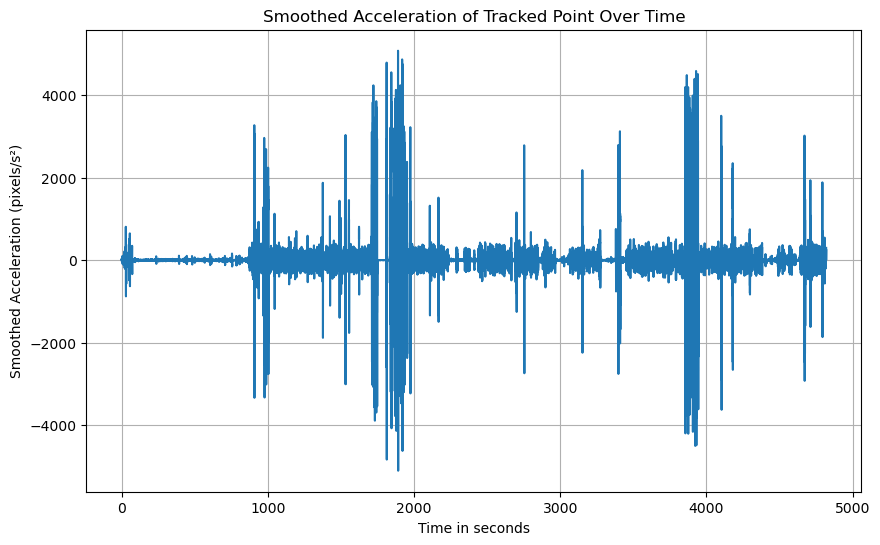

In [21]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Apply moving average for smoothing
window_size = 40  # Adjust as needed
smoothed_acceleration = moving_average(acceleration, window_size)

# Adjust time array for smoothed data
time_for_smoothed_acceleration = time_for_acceleration[:len(smoothed_acceleration)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_for_smoothed_acceleration, smoothed_acceleration)
plt.xlabel('Time in seconds')
plt.ylabel('Smoothed Acceleration (pixels/s²)')
plt.title('Smoothed Acceleration of Tracked Point Over Time')
plt.grid(True)
plt.show()

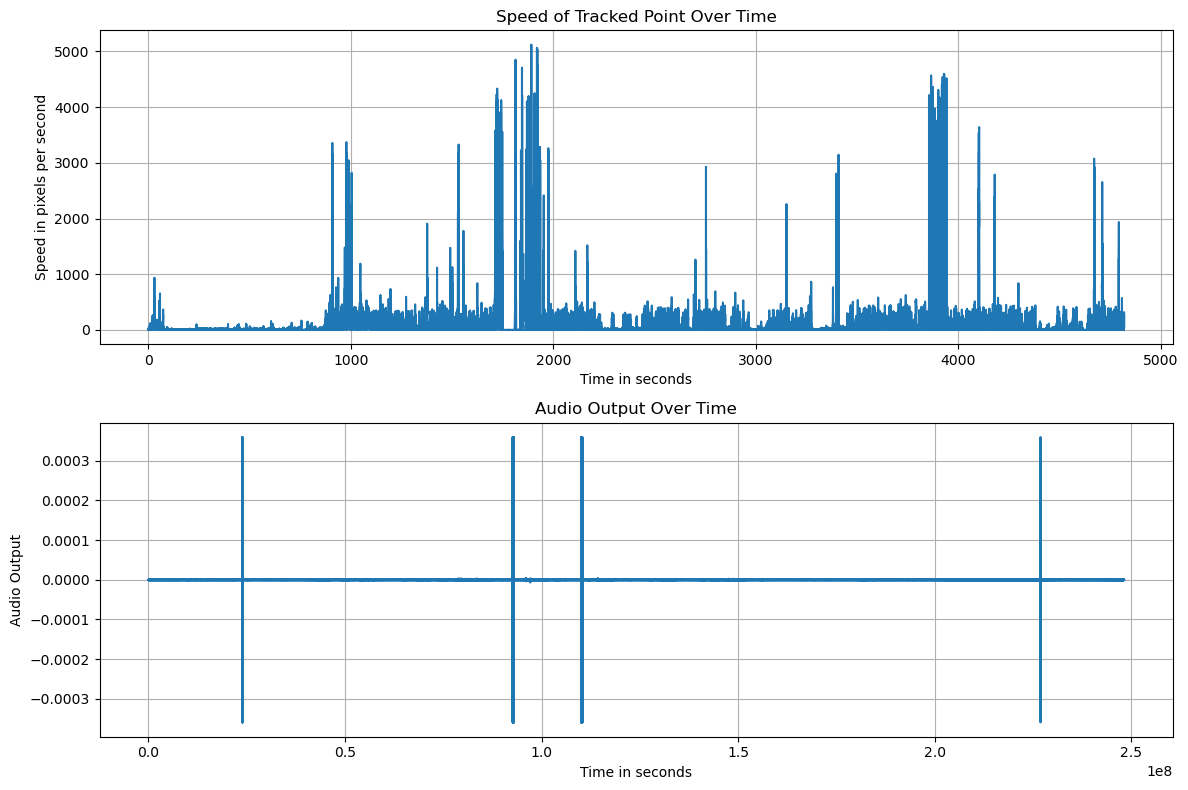

In [14]:
# Assuming you have the speed data and audio output data
speed_per_sec = speed_per_sec  # Speed data from video analysis
audio_output_data = audio_output_data/ 30000  # Audio data obtained from your process

# Video time array (40 FPS)
video_time = np.arange(len(speed_per_sec)) / 40  # For video frames

# Audio time array (30 kHz)
audio_time = np.arange(len(audio_output_data))   # For audio samples

# Plotting
plt.figure(figsize=(12, 8))

# Speed plot
plt.subplot(2, 1, 1)
plt.plot(video_time, speed_per_sec)
plt.xlabel('Time in seconds')
plt.ylabel('Speed in pixels per second')
plt.title('Speed of Tracked Point Over Time')
plt.grid(True)

# Audio output plot
plt.subplot(2, 1, 2)
plt.plot(audio_time, audio_output_data)
plt.xlabel('Time in seconds')
plt.ylabel('Audio Output')
plt.title('Audio Output Over Time')
plt.grid(True)

plt.tight_layout()
plt.show()


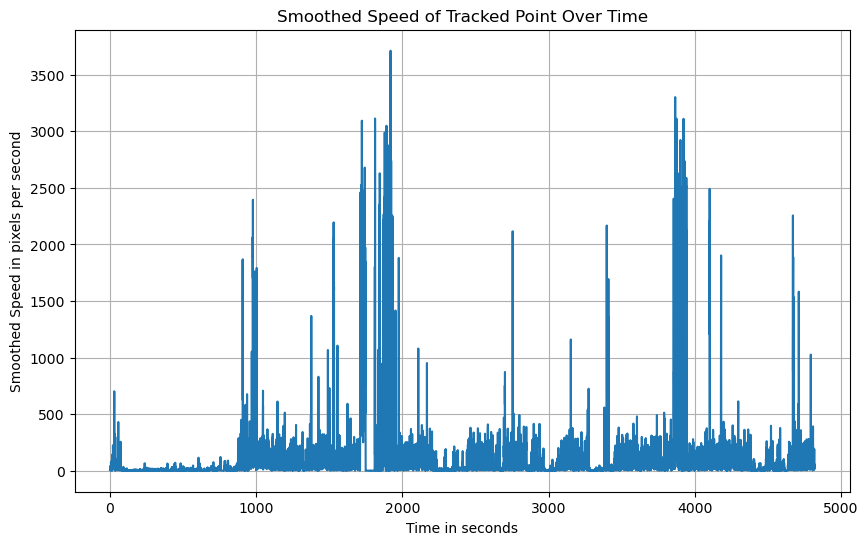

In [15]:
def moving_average(data, window_size):
    """ Calculate the moving average over a specified window size """
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Choose a window size for smoothing (e.g., 5, 10, 20 frames)
window_size = 20  # Adjust this value as needed

# Calculate moving average of speed
smoothed_speed = moving_average(speed_per_sec, window_size)

# Adjust time array to match the length of smoothed_speed
smoothed_time = time[:len(smoothed_speed)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(smoothed_time, smoothed_speed)
plt.xlabel('Time in seconds')
plt.ylabel('Smoothed Speed in pixels per second')
plt.title('Smoothed Speed of Tracked Point Over Time')
plt.grid(True)
plt.show()


In [64]:
import numpy as np

class MouseBehaviorAnalyzer:
    def __init__(self, lds_tracking_data):
        """
        Initialize the class with tracking data.
        :param lds_tracking_data: A dictionary containing Kalman-filtered coordinates for each body part.
        """
        self.lds_tracking_data = lds_tracking_data

    def compute_head_direction(self) -> np.ndarray:
        """
        This function computes the head direction of the mouse based on Kalman-filtered data.
        It calculates the angle between the line connecting the ears and a reference axis (e.g., towards the door of the rig).

        Returns:
            headDirection: A numpy array of head direction angles in radians, normalized to the range (-π, π].
        """
        # Extracting Kalman-filtered coordinates
        left_ear_x = self.lds_tracking_data['leftear']['x']
        left_ear_y = self.lds_tracking_data['leftear']['y']
        right_ear_x = self.lds_tracking_data['rightear']['x']
        right_ear_y = self.lds_tracking_data['rightear']['y']

        # Calculating deltas
        hedDelta_x = left_ear_x - right_ear_x
        hedDelta_y = left_ear_y - right_ear_y

        # Computing the head direction angle
        headDirection = -np.arctan2(hedDelta_y, hedDelta_x) - np.pi/2

        # Normalizing angles to range (-π, π]
        headDirection = (headDirection + np.pi) % (2 * np.pi) - np.pi

        return headDirection


In [65]:
# Sample Kalman-filtered data for mouse's left and right ears
lds_tracking_data = {
    'rightear': {
        'x': np.array(kalman_results['rightear']['x']),  # X-coordinates over time
        'y': np.array(kalman_results['rightear']['x'])   # Y-coordinates over time
    },
    'leftear': {
        'x': np.array(kalman_results['leftear']['x']),  # X-coordinates over time
        'y': np.array(kalman_results['leftear']['x'])   # Y-coordinates over time
    }
}


In [66]:
# Initialize the MouseBehaviorAnalyzer with the tracking data
analyzer = MouseBehaviorAnalyzer(lds_tracking_data)

# Compute the head direction
head_directions = analyzer.compute_head_direction()

# Print the computed head directions
print("Computed Head Directions:", head_directions)


Computed Head Directions: [ 0.78539816  0.78539816  0.78539816 ... -2.35619449 -2.35619449
 -2.35619449]


In [79]:
#let's see what values we have so far
# kalman_results
kalman_results


{'headcenter': {'x': array([522.11123736, 522.14258561, 522.16938609, ..., 685.57259664,
         679.32567662, 671.50162096]),
  'y': array([951.39373782, 951.42035587, 951.4556358 , ...,  92.12269035,
          86.18427661,  78.49372949])},
 'head_directions': array([1.39468144, 0.72929564, 0.81263629, ..., 0.52439966, 2.10140768,
        3.12842671])}

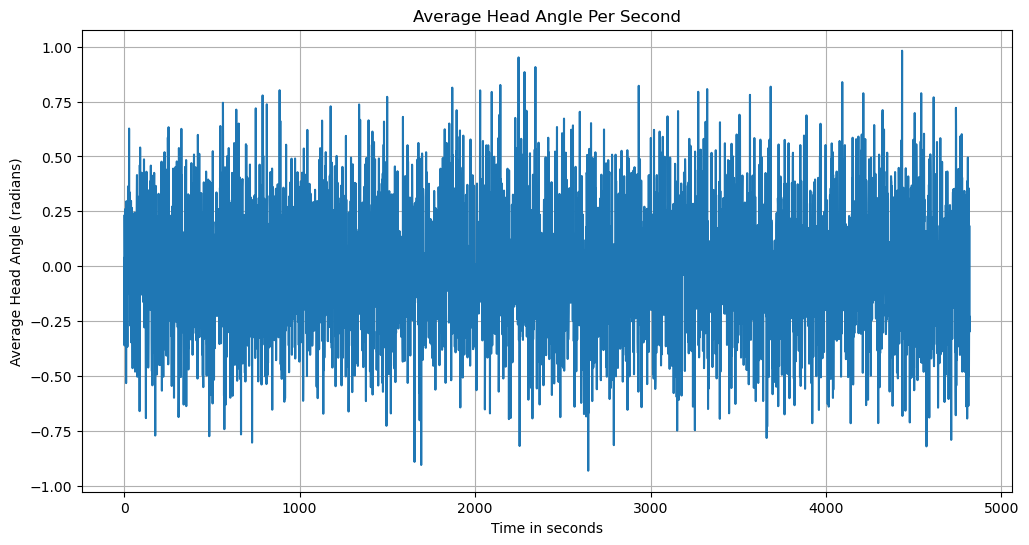

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# FPS and Time
fps = 40
num_frames = len(x_nose)
time_seconds = np.arange(num_frames) / fps

# Calculate head direction per second
# Initialize an empty list to store the average head direction per second
head_direction_per_sec = []

# Loop through each second
for i in range(0, num_frames, fps):
    # Calculate the average head direction for this second
    avg_direction = np.mean(head_directions[i:i+fps])
    head_direction_per_sec.append(avg_direction)

# Convert the list to a numpy array
head_direction_per_sec = np.array(head_direction_per_sec)

# New time array for the per-second data
time_per_sec = np.arange(len(head_direction_per_sec))

# Plotting
plt.figure(figsize=(12, 6))

# Plot head direction per second
plt.plot(time_per_sec, head_direction_per_sec)
plt.xlabel('Time in seconds')
plt.ylabel('Average Head Angle (radians)')
plt.title('Average Head Angle Per Second')
plt.grid(True)

plt.show()


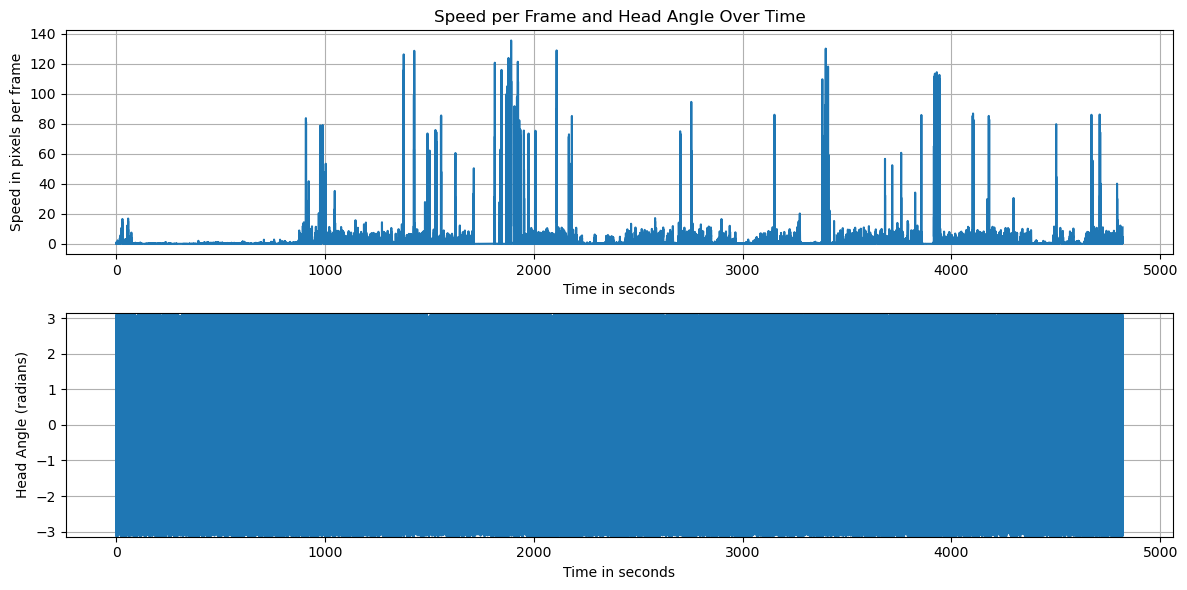

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data structure (replace this with your actual data)
kalman_results = {
    'headcenter': {
        'x': np.array(kalman_results['headcenter']['x']),  # Replace with actual x data
        'y': np.array(kalman_results['headcenter']['y']),  # Replace with actual y data
    },
    # Add head direction data here
    'head_directions': head_directions # Replace with actual head direction data
}

# Extract nose coordinates and head directions
x_nose = np.array(kalman_results['headcenter']['x'])
y_nose = np.array(kalman_results['headcenter']['y'])
head_directions = np.array(kalman_results['head_directions'])  # Head direction for each frame

# Number of frames
num_frames = len(x_nose)

# Calculate time for each frame
fps = 40  # FPS as specified
time = np.arange(num_frames) / fps

# Calculate speed in pixels per frame
speed_per_frame = np.sqrt(np.diff(x_nose)**2 + np.diff(y_nose)**2)

# Plot speed per frame
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time[:-1], speed_per_frame)  # Exclude the last time point
plt.xlabel('Time in seconds')
plt.ylabel('Speed in pixels per frame')
plt.title('Speed per Frame and Head Angle Over Time')
plt.grid(True)

# Plot head direction (angle)
plt.subplot(2, 1, 2)
plt.plot(time, head_directions)  # Use all time points for head direction
plt.xlabel('Time in seconds')
plt.ylabel('Head Angle (radians)')
plt.ylim(-np.pi, np.pi)  # Adjust this as needed
plt.grid(True)

plt.tight_layout()  # Adjusts the plots to provide sufficient spacing
plt.show()


In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

def load_shelter_coords(filepath):
    return np.load(filepath)

def plot_tracking_data(ax, tracking_data, start_frame, colors, ROIs, bodypart):
    for i, (roi_key, roi_points) in enumerate(ROIs.items()):
        draw_roi(ax, roi_points, colors[i], roi_key)
    ax.plot(tracking_data[bodypart]['x'][start_frame:], tracking_data[bodypart]['y'][start_frame:], 'b.', markersize=1)
    ax.invert_yaxis()

def draw_roi(ax, roi_points, color, label, zorder=5):
    poly = patches.Polygon(roi_points, linewidth=3, edgecolor=color, facecolor='none', closed=True, zorder=zorder)
    ax.add_patch(poly)
    centroid = np.mean(roi_points, axis=0)
    ax.text(centroid[0], centroid[1], label, color=color, ha='center', va='center')

def calculate_time_in_ROIs(tracking_data, start_frame, ROIs, fps,):
    time_in_ROIs = {key: 0 for key in ROIs}
    for i in range(start_frame, len(tracking_data)):
        point = (tracking_data[bodypart]['x'][i], tracking_data[bodypart]['y'][i])
        for roi_key, roi in ROIs.items():
            if is_inside_roi(point, roi):
                time_in_ROIs[roi_key] += 1
    return {key: value / fps for key, value in time_in_ROIs.items()}

def main(tracking_data, shelter_coords_path, start_frame, fps):
    shelter_coords = load_shelter_coords(shelter_coords_path)
    ROIs = {
        'Shelter1': shelter_coords[0:4],
        'Shelter2': shelter_coords[4:8],
        'Shelter3': shelter_coords[8:12]
    }

    fig, ax = plt.subplots()
    plot_tracking_data(ax, tracking_data, start_frame, ['r', 'g', 'b'], ROIs)
    plt.show()

    time_in_ROIs_seconds = calculate_time_in_ROIs(tracking_data, start_frame, ROIs, fps)
    print("Time spent in each shelter (in seconds):", time_in_ROIs_seconds)


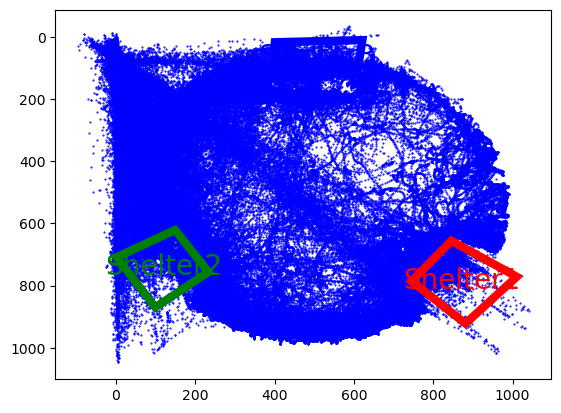

Time spent in each shelter (in seconds): {'Shelter1': 0.0, 'Shelter2': 0.0, 'Shelter3': 0.0}


In [199]:
# Example usage
shelter_coords_path = '/Users/chenx/Desktop/Branco Lab/Shelter Choice Project/DLC_analysis/mouseid-1119976_shelter_coords.npy'
tracking_data = kalman_results_mouse_1119976_df
start_frame = 6559 * 40  # Adjust as needed
fps = 40  # Adjust to the actual FPS of your video

main(tracking_data, shelter_coords_path, start_frame, fps,bodypart='headcenter')

/Users/chenx/miniconda/envs/DLC_post_analysis/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


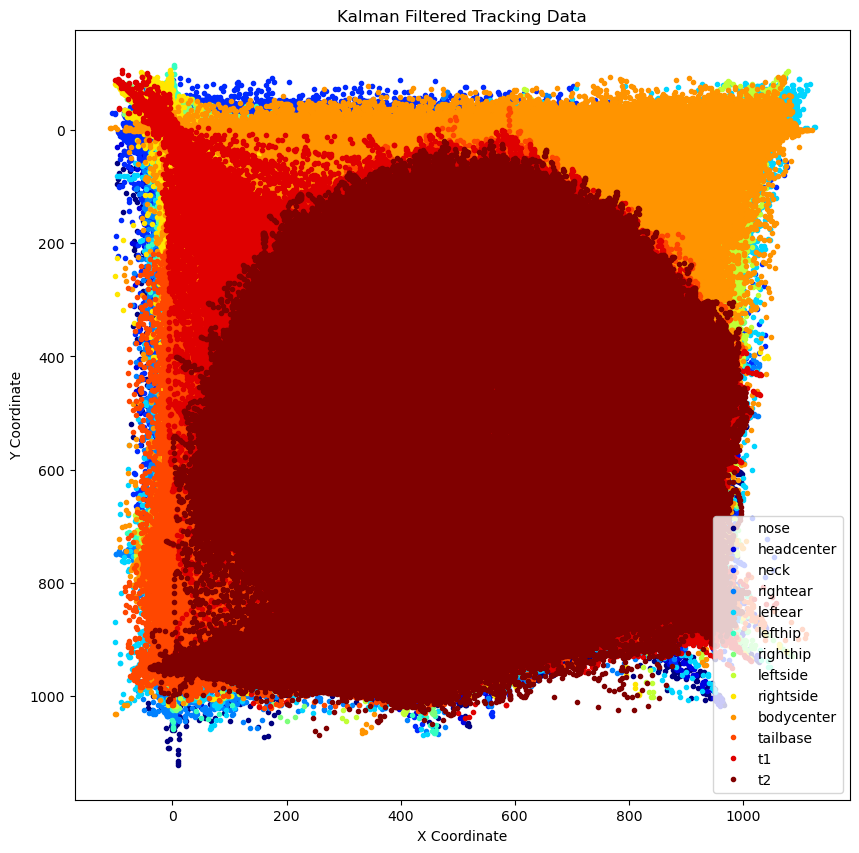

In [189]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_body_parts(df, bodyparts, colors):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    for bp, color in zip(bodyparts, colors):
        ax.plot(df[bp]['x'], df[bp]['y'], '.', color=color, label=bp)

    # Reverse the y-axis to match the image coordinate system
    ax.invert_yaxis()

    plt.legend()
    plt.title("Kalman Filtered Tracking Data")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

# Assuming 'df' is your DataFrame
# For example: df = pd.DataFrame({'nose': {'x': [...], 'y': [...]}, 'tail': {'x': [...], 'y': [...]}, ...})

# List of body parts to plot
bodyparts = ['nose', 'headcenter', 'neck', 'rightear', 'leftear', 'lefthip', 'righthip', 'leftside', 'rightside', 'bodycenter', 'tailbase', 't1', 't2']

# Generate distinct colors for each body part
colors = plt.cm.jet(np.linspace(0, 1, len(bodyparts)))

plot_body_parts(kalman_results_mouse_1119976_df, bodyparts, colors)
